In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import numpy
from sklearn.metrics import precision_recall_curve 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import xgboost


In [2]:
print(xgboost.__version__)



1.4.0


In [3]:
raw_raw = pd.read_csv('data/covtype.csv')

#From covertype.info: 
    
 First digit:  climatic zone             Second digit:  geologic zones
                1.  lower montane dry                   1.  alluvium
                2.  lower montane                       2.  glacial
                3.  montane dry                         3.  shale
                4.  montane                             4.  sandstone
                5.  montane dry and montane             5.  mixed sedimentary
                6.  montane and subalpine               6.  unspecified in the USFS ELU Survey
                7.  subalpine                           7.  igneous and metamorphic
                8.  alpine                              8.  volcanic

        The third and fourth ELU digits are unique to the mapping unit 
        and have no special meaning to the climatic or geologic zones.   

In [4]:
climate_zone = ['none-zero-place-holder', 'lower_montane_dry','lower_montane','montane_dry', 'montane','montane_dry_and_montane','montane_and_subalpine','subalpine','alpine']
geologic_zone = ['none-zero-place-holder','alluvium','glacial','shale','sandstone','mixed_sedimentary','unspecified', 'ingeous_and_metamorphic','volcanic']


In [5]:
soil_type_decoding = pd.read_csv('data/soil_type_details.txt', sep="\t")
soil_type_decoding.columns=['index','elu_code','none','description']
soil_type_decoding = soil_type_decoding[['index','elu_code','description']]
soil_type_decoding['decoding'] = soil_type_decoding['description'] 
soil_type_decoding[['name','decoding']] = soil_type_decoding.decoding.str.split('-',1,expand=True)

In [6]:
soil_type_decoding['climate_zone_code'] = (soil_type_decoding['elu_code']/1000).astype('int')
soil_type_decoding['climate_zone'] = soil_type_decoding['climate_zone_code'].apply(lambda x: climate_zone[x])
soil_type_decoding['geo_zone_code'] = (soil_type_decoding['elu_code']%1000/100).astype('int')
soil_type_decoding['geo_zone'] = soil_type_decoding['geo_zone_code'].apply(lambda x: geologic_zone[x])
soil_type_decoding['index'] = soil_type_decoding['index'].astype('int')

In [7]:
raw_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [8]:
def undummy(d):
    return d.dot(d.columns)
raw0 = raw_raw.copy()
raw0['soil'] = raw0.filter(regex='^Soil_Type').pipe(undummy).str.split('Soil_Type').apply(lambda x: x[1])
raw0['wilderness'] = raw0.filter(regex='^Wilderness_Area').pipe(undummy).str.split('Wilderness_Area').apply(lambda x: x[1])

decode_cover = ["none", "Spruce/Fir", "Lodgepole Pine","Ponderosa Pine", "Cottonwood/Willow", "Aspen", "Douglas Fir", "Krummholz"]
raw0['cover_type_code']=raw0['Cover_Type'].copy()
raw0['cover_type']=raw0['cover_type_code'].apply(lambda x: decode_cover[x])
print(raw0.dtypes)

Elevation                              int64
Aspect                                 int64
Slope                                  int64
Horizontal_Distance_To_Hydrology       int64
Vertical_Distance_To_Hydrology         int64
Horizontal_Distance_To_Roadways        int64
Hillshade_9am                          int64
Hillshade_Noon                         int64
Hillshade_3pm                          int64
Horizontal_Distance_To_Fire_Points     int64
Wilderness_Area1                       int64
Wilderness_Area2                       int64
Wilderness_Area3                       int64
Wilderness_Area4                       int64
Soil_Type1                             int64
Soil_Type2                             int64
Soil_Type3                             int64
Soil_Type4                             int64
Soil_Type5                             int64
Soil_Type6                             int64
Soil_Type7                             int64
Soil_Type8                             int64
Soil_Type9

In [9]:
raw1 = raw0[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points','wilderness','soil','cover_type_code','cover_type']]
raw1.columns = ['elevation', 'aspect', 'slope', 'h_water',
       'v_water', 'h_road',
       'shade_9', 'shade_noon', 'shade_3',
       'h_fire','wilderness','soil_type','cover_type_code','cover_type']
raw1['soil_type'] = raw1.soil_type.astype('int')

/var/folders/9k/83m77rxs5835tnj2rh39wf3h0000gn/T/ipykernel_61756/3597294847.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw1['soil_type'] = raw1.soil_type.astype('int')


In [10]:
df = pd.merge(raw1, soil_type_decoding[['index','description','decoding','name','climate_zone','geo_zone']], left_on='soil_type', right_on='index')
df['soil_type']=df['soil_type'].astype('object')
df = df[['elevation', 'aspect', 'slope', 'h_water', 'v_water', 'h_road',
       'shade_9', 'shade_noon', 'shade_3', 'h_fire', 'wilderness', 'soil_type',
       'cover_type_code','cover_type', 'description', 'decoding', 'name',
       'climate_zone', 'geo_zone']]
df.columns = ['elevation', 'aspect', 'slope', 'h_water', 'v_water', 'h_road',
       'shade_9', 'shade_noon', 'shade_3', 'h_fire', 'wilderness', 'soil_type',
       'cover_type_code','cover_type', 'soil_description', 'soil_decoding', 'soil_name',
       'climate_zone', 'geo_zone']
df['slope_direction'] =  df['aspect'].apply(lambda x: (((x+45)%360)/90)).astype('int').replace({0:"north", 1:"east", 2:"south",3:"west"})
display(df.groupby('cover_type').count())
df['tree'] = (df.cover_type == 'Spruce/Fir').astype('int')

,elevation,aspect,slope,h_water,v_water,h_road,shade_9,shade_noon,shade_3,h_fire,wilderness,soil_type,cover_type_code,soil_description,soil_decoding,soil_name,climate_zone,geo_zone,slope_direction
cover_type,,,,,,,,,,,,,,,,,,,
Aspen,9493,9493,9493,9493,9493,9493,9493,9493,9493,9493,9493,9493,9493,9493,9253,9493,9493,9493,9493
Cottonwood/Willow,2747,2747,2747,2747,2747,2747,2747,2747,2747,2747,2747,2747,2747,2747,2747,2747,2747,2747,2747
Douglas Fir,17367,17367,17367,17367,17367,17367,17367,17367,17367,17367,17367,17367,17367,17367,17229,17367,17367,17367,17367
Krummholz,20510,20510,20510,20510,20510,20510,20510,20510,20510,20510,20510,20510,20510,20510,20158,20510,20510,20510,20510
Lodgepole Pine,283301,283301,283301,283301,283301,283301,283301,283301,283301,283301,283301,283301,283301,283301,264044,283301,283301,283301,283301
Ponderosa Pine,35754,35754,35754,35754,35754,35754,35754,35754,35754,35754,35754,35754,35754,35754,35754,35754,35754,35754,35754
Spruce/Fir,211840,211840,211840,211840,211840,211840,211840,211840,211840,211840,211840,211840,211840,211840,174698,211840,211840,211840,211840


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

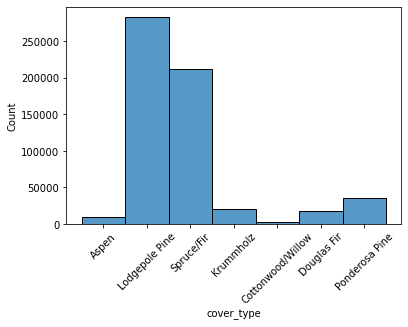

In [11]:
ax = sns.histplot(x="cover_type", data=df)
plt.xticks(rotation=45)
#Spruce and Lodgepole Pine are most common 
#Cottonwood is rarest and Aspen


<AxesSubplot:xlabel='elevation', ylabel='Count'>

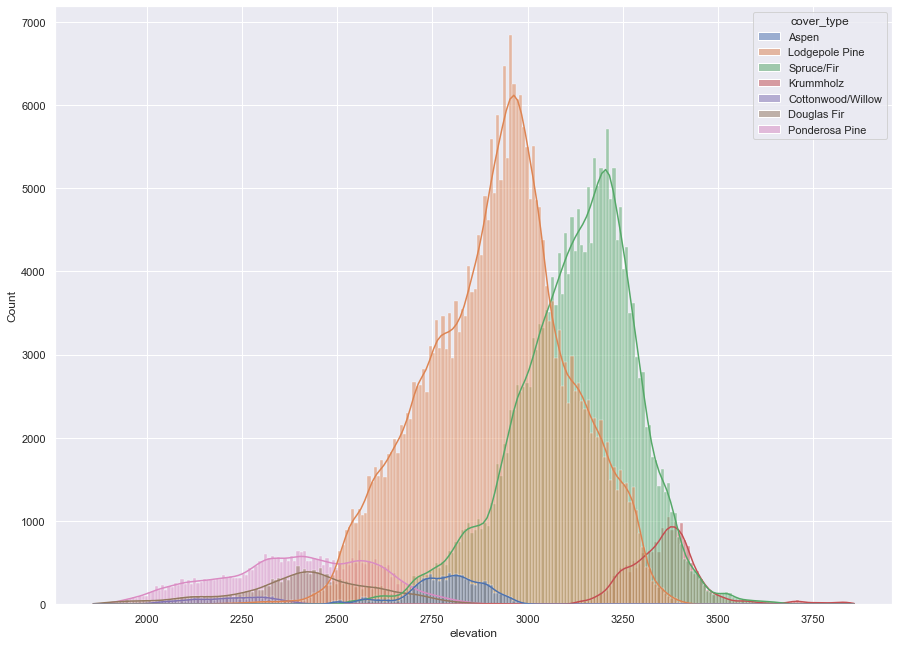

In [12]:
sns.set(rc={'figure.figsize':(15,11)})
sns.histplot(data=df, x="elevation", hue='cover_type',kde=True)
#Elevation looks like a good feature - they differ a bit for each group. 

<AxesSubplot:xlabel='cover_type', ylabel='elevation'>

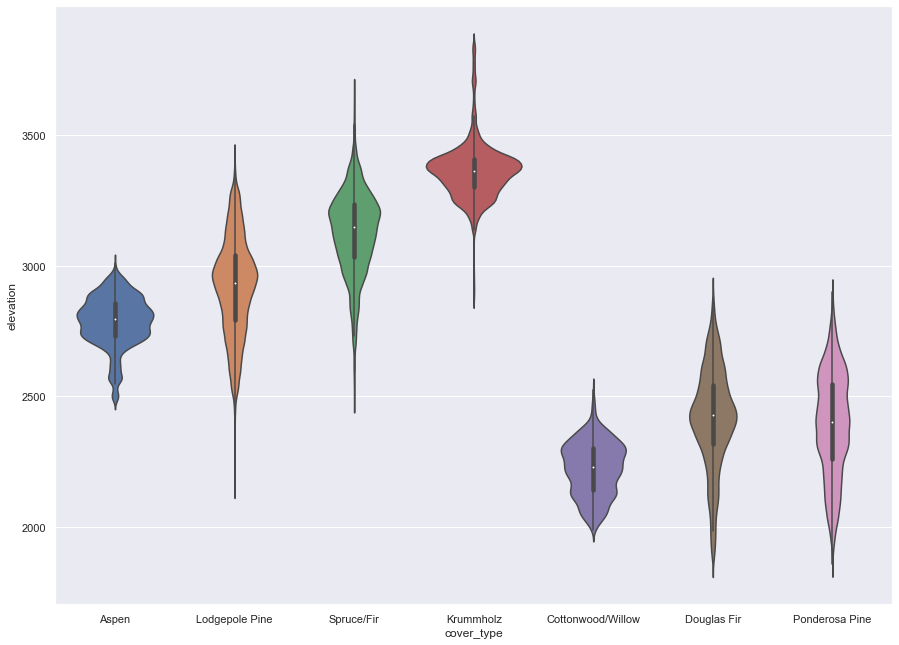

In [13]:
sns.violinplot(data=df, x="cover_type", y="elevation")

<AxesSubplot:xlabel='cover_type', ylabel='aspect'>

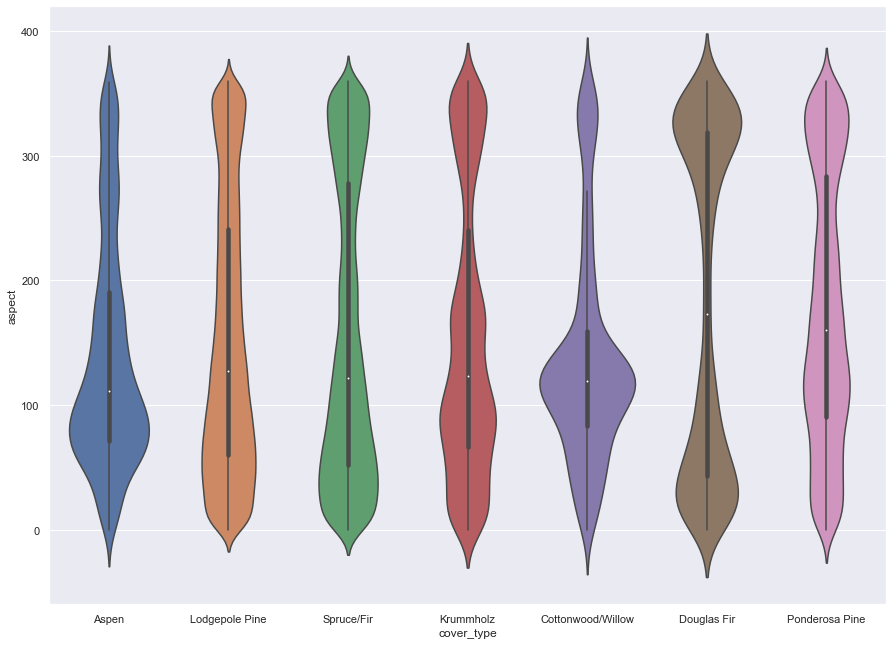

In [14]:
sns.violinplot(data=df, x="cover_type", y="aspect")

<AxesSubplot:xlabel='slope', ylabel='Count'>

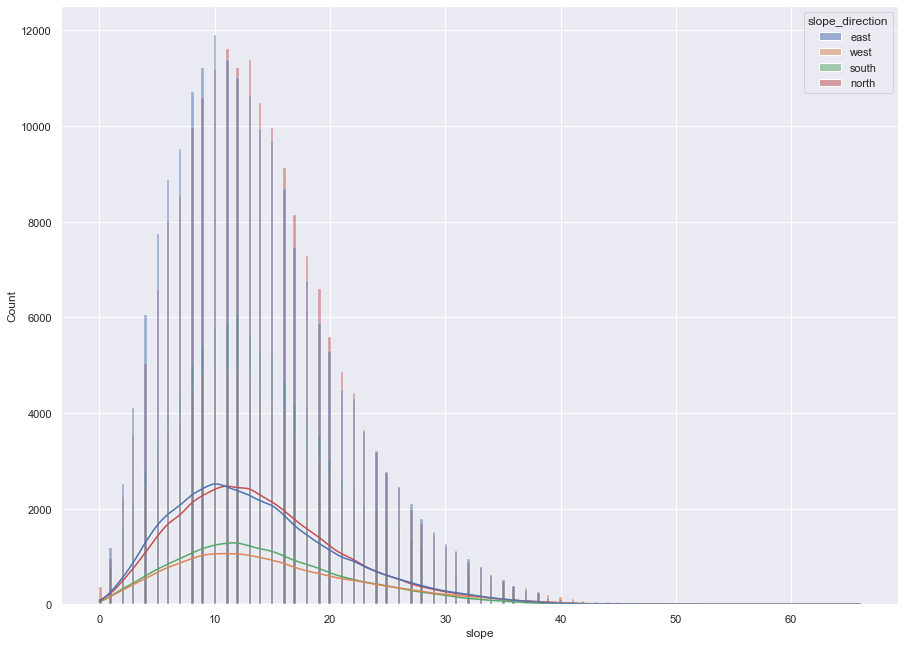

In [15]:
sns.histplot(data=df, hue="slope_direction", x="slope", kde=True)
#So slope isnt a great indicator by itself it looks like 
#not for direction, not for cover type 

<AxesSubplot:xlabel='soil_type', ylabel='elevation'>

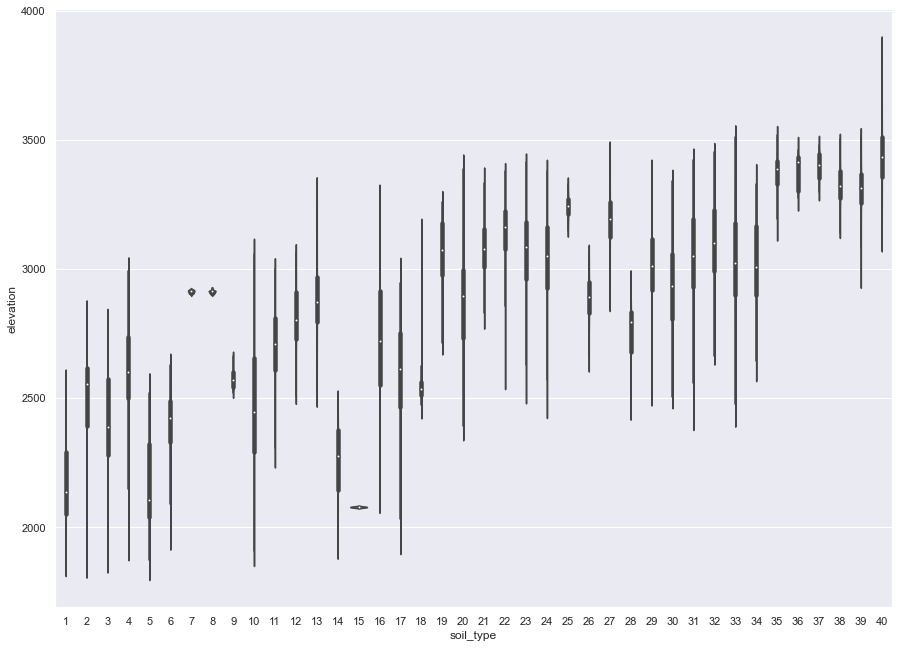

In [16]:
sns.violinplot(data=df, x="soil_type", y="elevation")

,elevation,slope,aspect,h_water,v_water,h_road,shade_9,shade_noon,shade_3,h_fire,...,soil_type,cover_type_code,cover_type,soil_description,soil_decoding,soil_name,climate_zone,geo_zone,slope_direction,tree
0,1859,12,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1860,13,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1861,14,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1863,17,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1866,14,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:xlabel='elevation', ylabel='slope'>

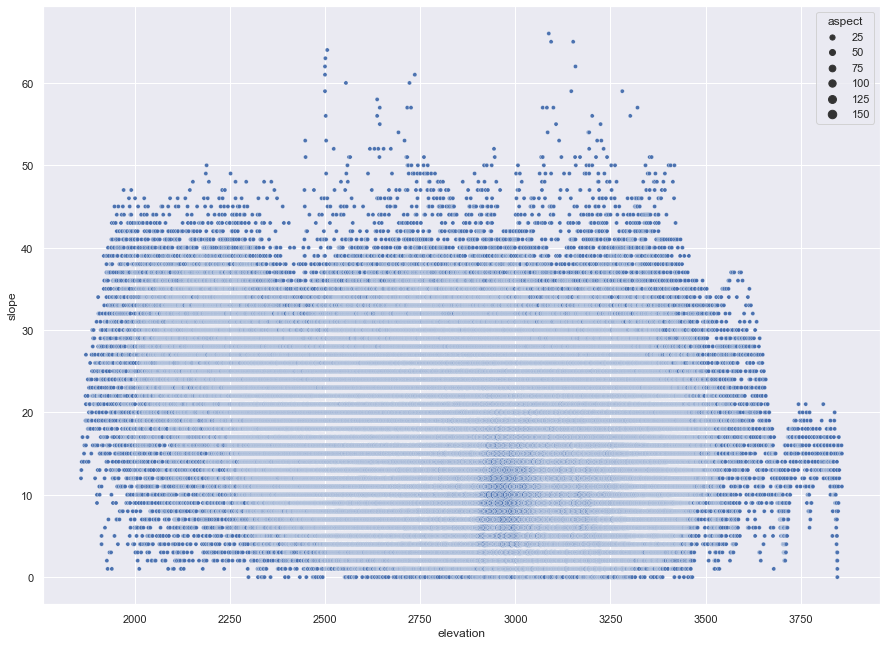

In [17]:
b = df.groupby(['elevation','slope'],as_index=False).count()
display(b.head())
sns.scatterplot(data=b, x='elevation', y='slope', size='aspect')


In [18]:
b = df.groupby(['elevation','slope_direction'],as_index=False).count()
b.head()
#sns.violinplot(data=df, y='elevation', x='slope_direction')
#We're pretty evenly north south east west, without much of a difference for elevation in direction. 


,elevation,slope_direction,aspect,slope,h_water,v_water,h_road,shade_9,shade_noon,shade_3,...,wilderness,soil_type,cover_type_code,cover_type,soil_description,soil_decoding,soil_name,climate_zone,geo_zone,tree
0,1859,north,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1860,north,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1861,north,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1863,north,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1866,north,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:xlabel='slope', ylabel='Count'>

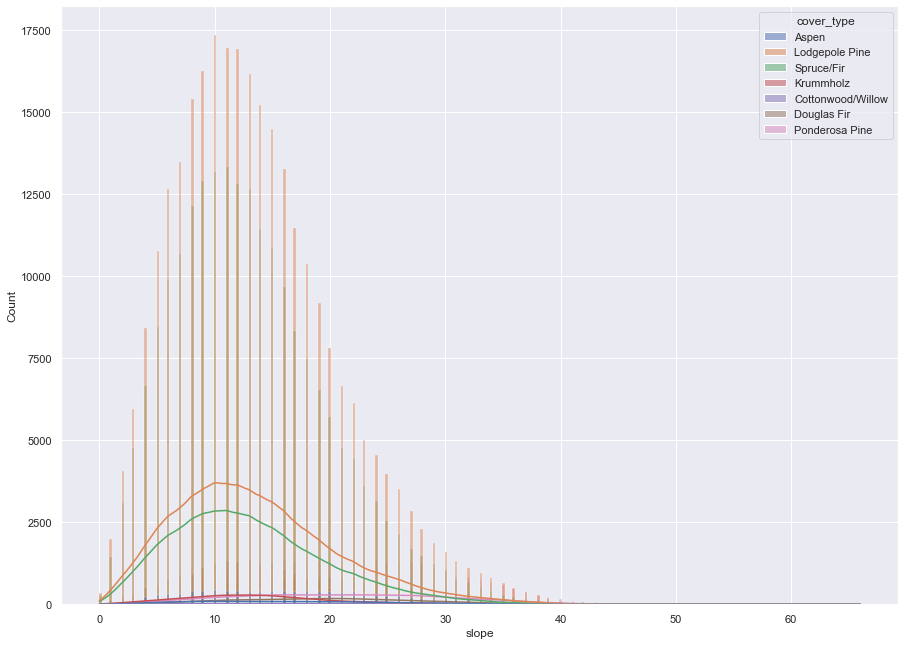

In [19]:
sns.histplot(data=df, x='slope',hue='cover_type',kde=True)

<AxesSubplot:xlabel='h_water', ylabel='elevation'>

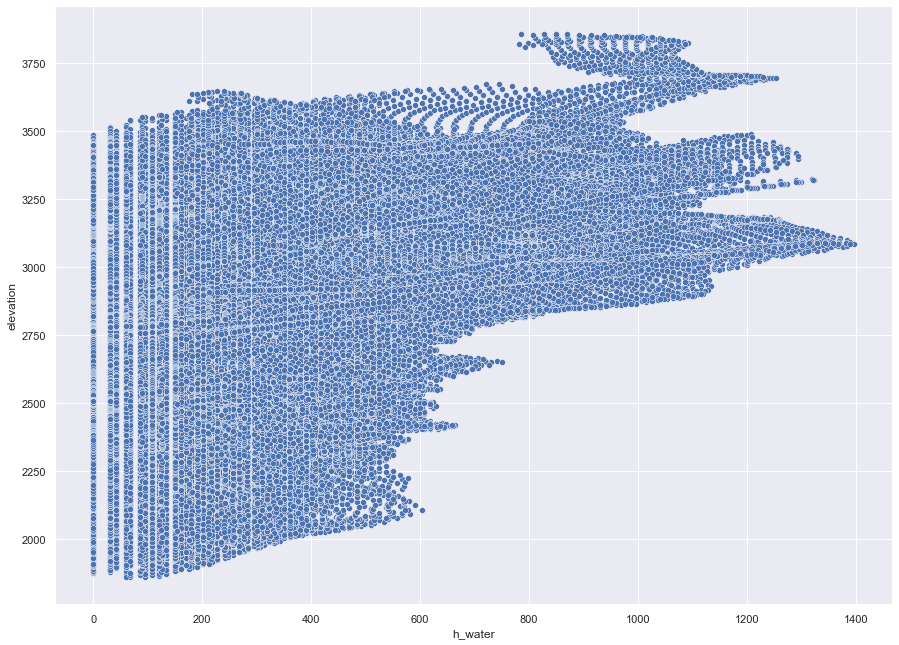

In [20]:
sns.scatterplot(data=df, x='h_water',y='elevation')

In [21]:
def do_data_split(a, row = ['elevation','aspect','slope','h_water','v_water','h_road','shade_9', 'shade_noon','shade_3','h_fire','wilderness','climate_zone','geo_zone','slope_direction','soil_name','soil_type'], percent_train=.6):
    percent_test = (1 - percent_train)/2
    percent_val = percent_test/(1-percent_test)
    X_full = a[row]
    y_full = a.tree
    X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=percent_test, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=percent_val, random_state=3)
    return ((X_train, y_train), (X_val, y_val), (X_test, y_test))
 

In [22]:
df2  = df.copy()

<AxesSubplot:xlabel='soil_name', ylabel='Count'>

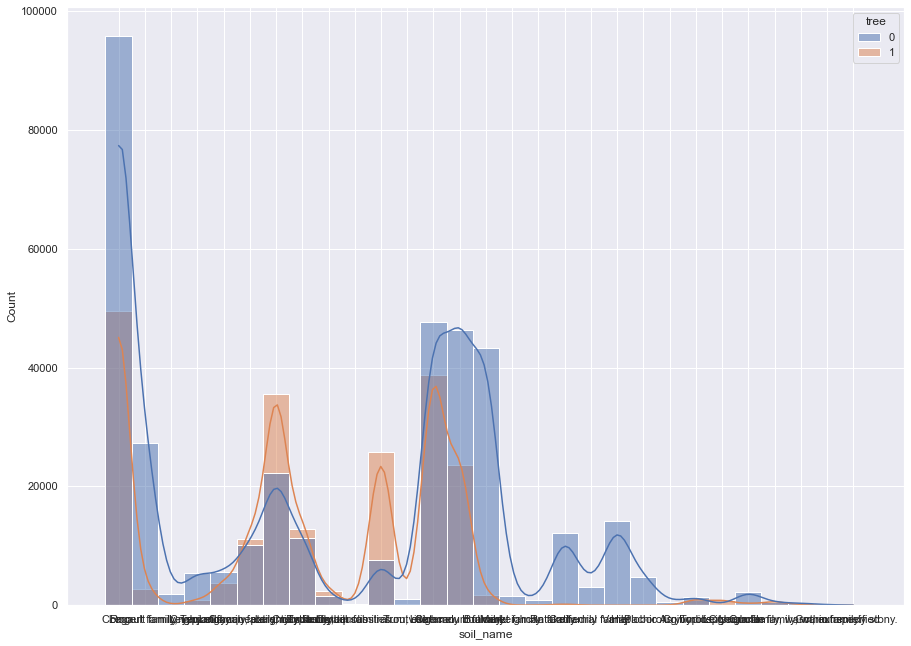

In [23]:
#sns.histplot(data=a, x='elevation', hue='tree')
sns.histplot(data=df2, x='soil_name', hue='tree', kde=True)

<AxesSubplot:xlabel='slope', ylabel='Count'>

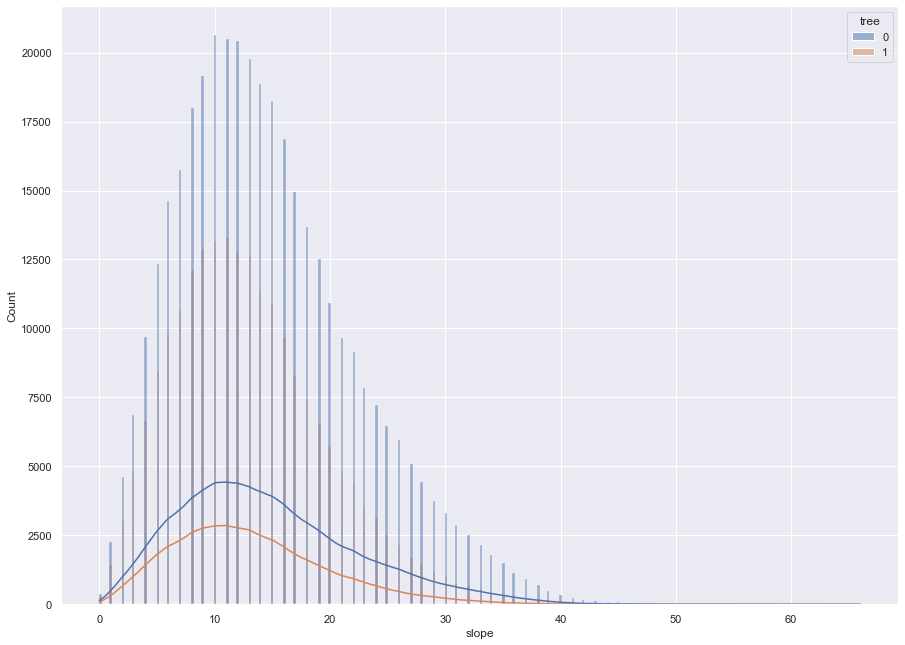

In [24]:
sns.histplot(data=df2, x='slope', hue='tree',kde=True)

<AxesSubplot:xlabel='h_water', ylabel='Count'>

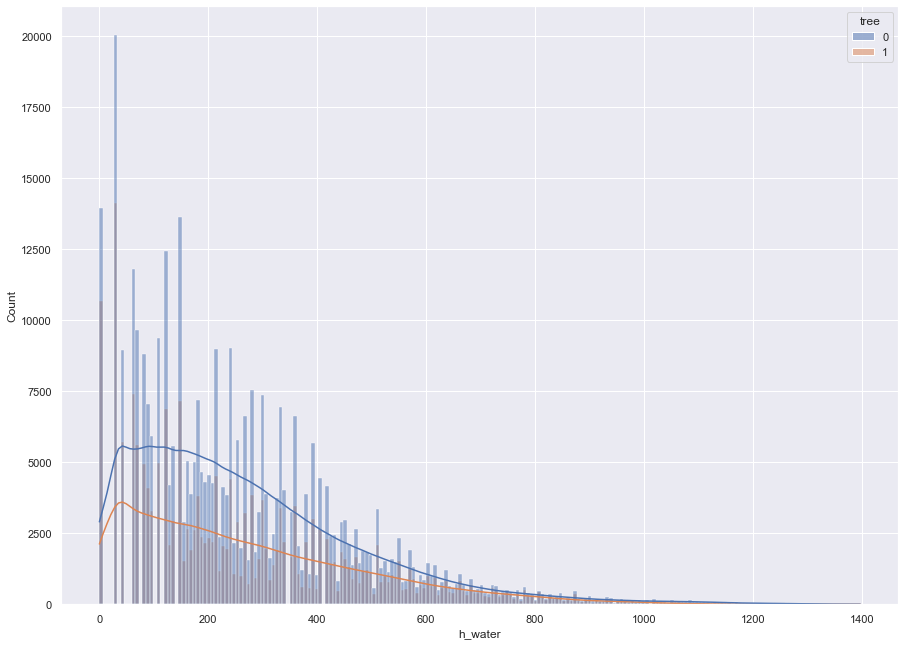

In [25]:
sns.histplot(data=df2, x='h_water', hue='tree',kde=True)

<AxesSubplot:xlabel='v_water', ylabel='Count'>

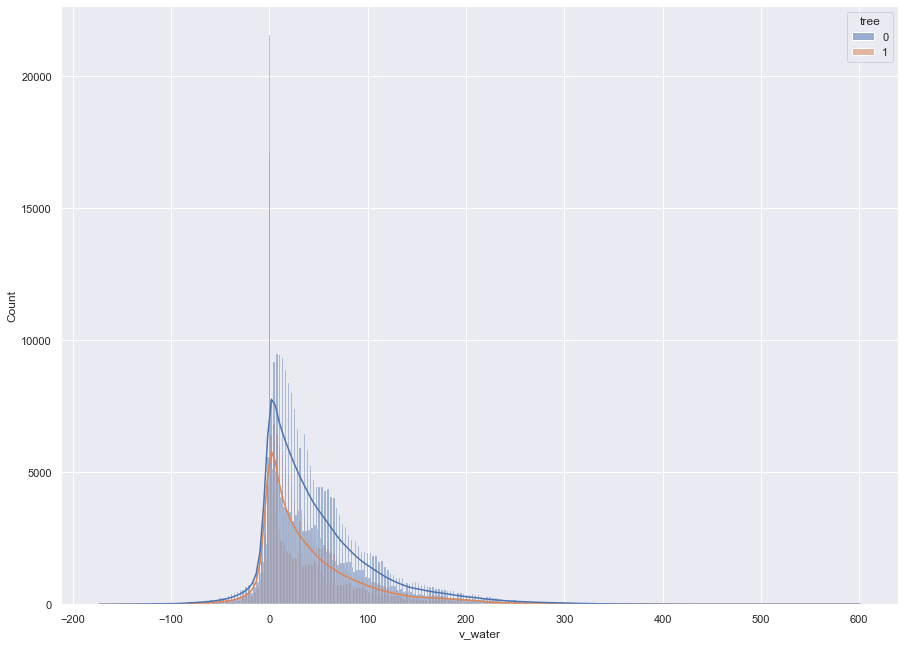

In [26]:
sns.histplot(data=df2, x='v_water', hue='tree',kde=True)

<AxesSubplot:xlabel='h_road', ylabel='Count'>

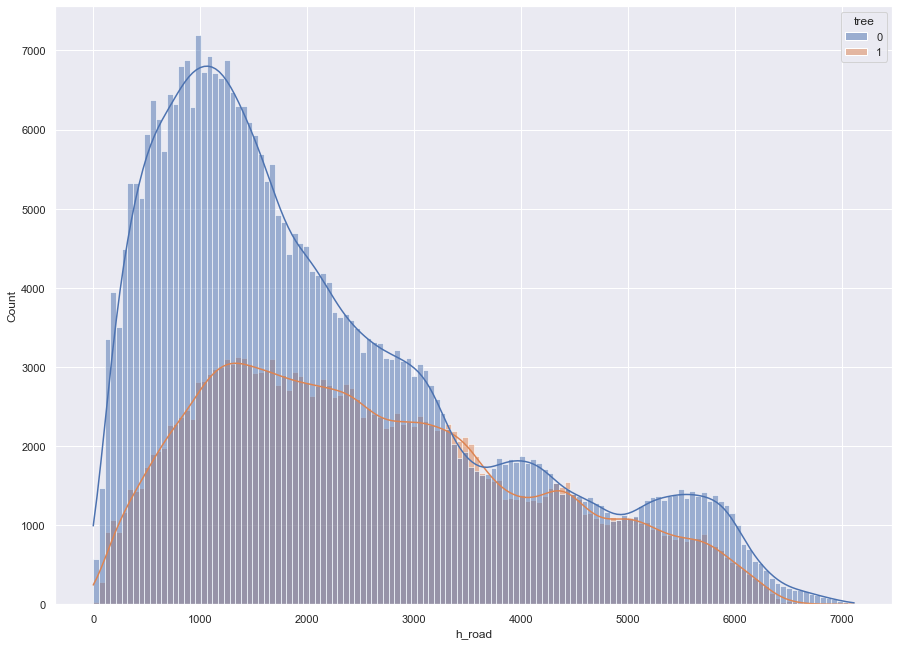

In [27]:
sns.histplot(data=df2, x='h_road', hue='tree',kde=True)

<AxesSubplot:xlabel='h_fire', ylabel='Count'>

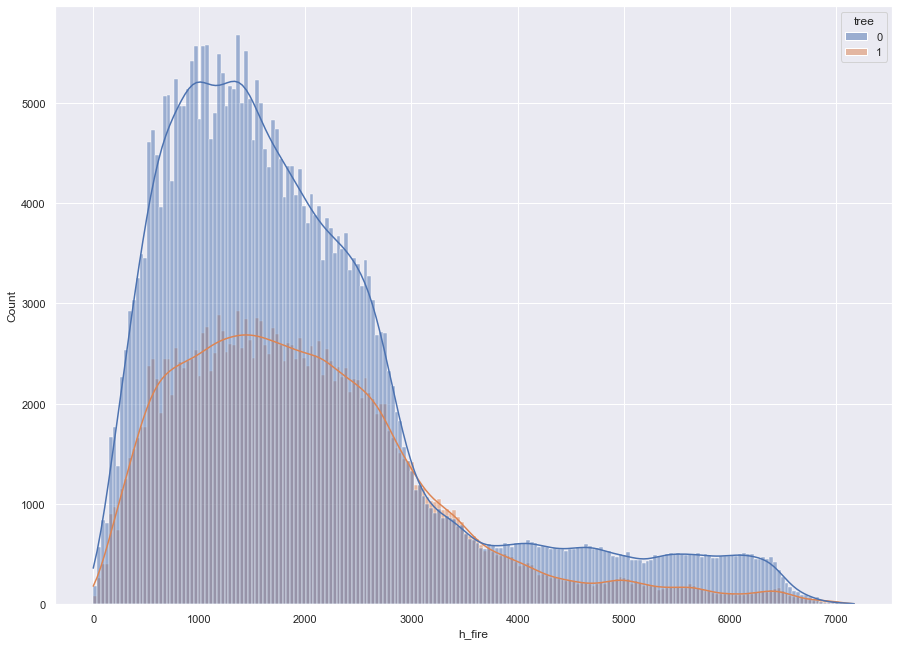

In [28]:
sns.histplot(data=df2, x='h_fire', hue='tree',kde=True)

<AxesSubplot:xlabel='shade_9', ylabel='Count'>

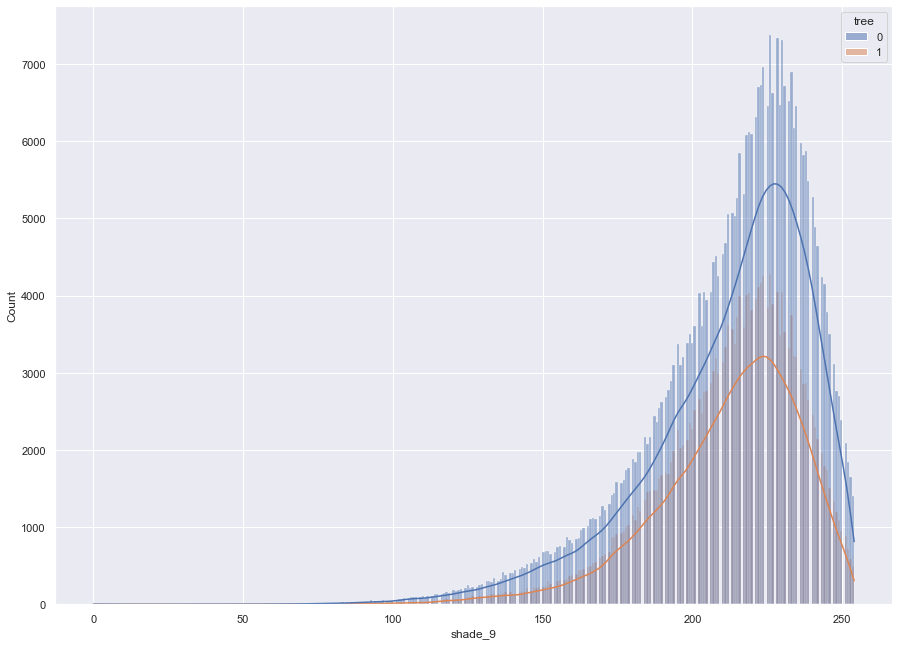

In [29]:
sns.histplot(data=df2, x='shade_9', hue='tree', kde=True)

<AxesSubplot:xlabel='shade_noon', ylabel='Count'>

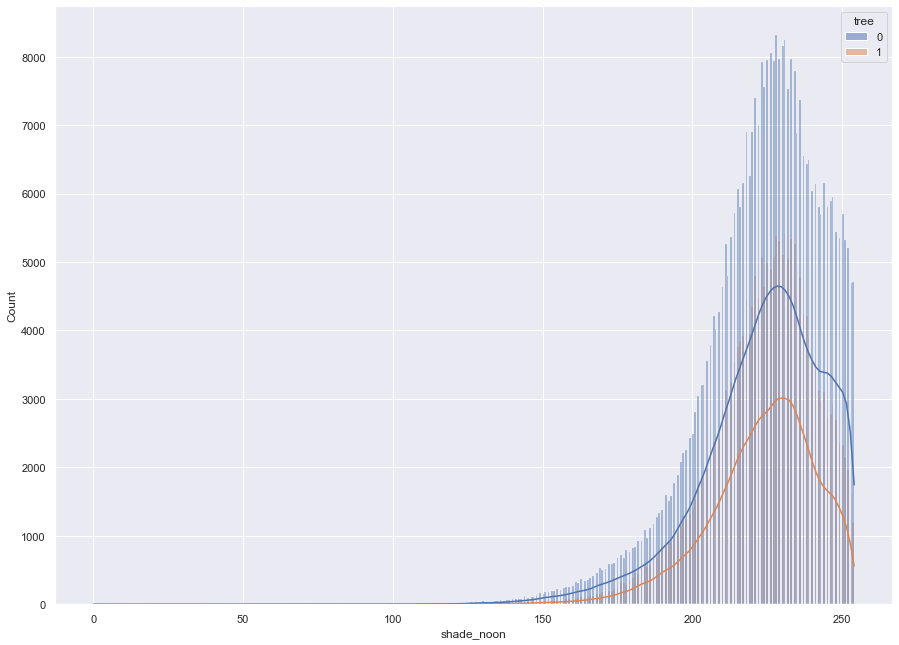

In [30]:
sns.histplot(data=df2, x='shade_noon', hue='tree', kde=True)

<AxesSubplot:xlabel='shade_3', ylabel='Count'>

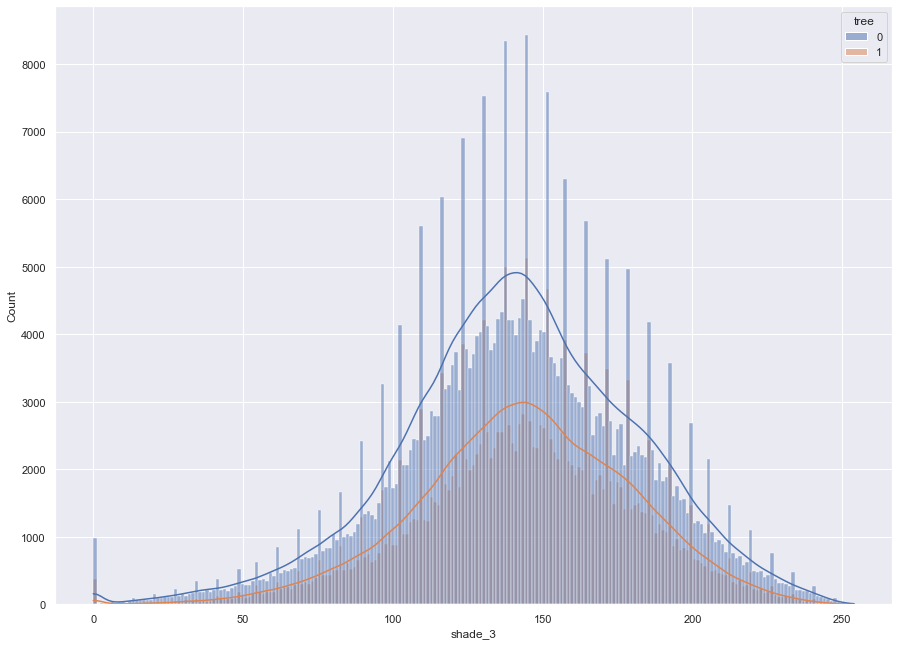

In [31]:
sns.histplot(data=df2, x='shade_3', hue='tree', kde=True)

<AxesSubplot:xlabel='wilderness', ylabel='Count'>

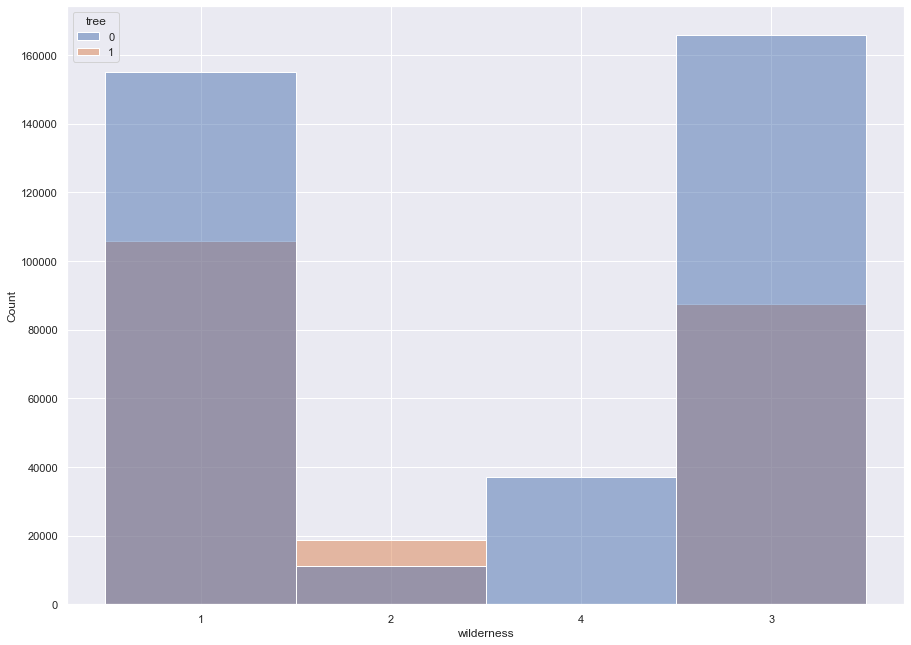

In [32]:
sns.histplot(data=df2, x='wilderness', hue='tree')

In [33]:
raw = pd.get_dummies(df)
raw.shape
df.dtypes

elevation            int64
aspect               int64
slope                int64
h_water              int64
v_water              int64
h_road               int64
shade_9              int64
shade_noon           int64
shade_3              int64
h_fire               int64
wilderness          object
soil_type           object
cover_type_code      int64
cover_type          object
soil_description    object
soil_decoding       object
soil_name           object
climate_zone        object
geo_zone            object
slope_direction     object
tree                 int64
dtype: object

In [34]:
# print(raw.columns[0:50])
# print(raw.columns[51:119])
# print(raw.columns[120:])

In [86]:
# So: 
#df2 is my full df with the tree binary 
#Lets run a logreg with elevation: 

row = ['elevation', 'aspect', 'slope', 'h_water', 'v_water', 'h_road',
       'shade_9', 'shade_noon', 'shade_3', 'h_fire', 'wilderness',
       'climate_zone', 'geo_zone', 'slope_direction',
       'soil_type']
train, val, test = do_data_split(df,row, percent_train=.2)

print(len(train[0]))
print(len(val[0]))
print(len(test[0]))


print(train[0].columns)
display(train[1].value_counts()[1]/train[1].value_counts()[0])
display(df.tree.value_counts()[1]/df.tree.value_counts()[0])

#So: spruce is super common  - it was chosen that way intentionally. 
# Proportion in training matches that in original data (although whether I am cheating by picking the largest group remains to be seen:) 

116202
232405
232405
Index(['elevation', 'aspect', 'slope', 'h_water', 'v_water', 'h_road',
       'shade_9', 'shade_noon', 'shade_3', 'h_fire', 'wilderness',
       'climate_zone', 'geo_zone', 'slope_direction', 'soil_type'],
      dtype='object')


0.5727627091115803

0.5738246670928456

In [87]:
row = ['elevation', 'aspect', 'slope', 'h_water', 'v_water', 'h_road',
       'shade_9', 'shade_noon', 'shade_3', 'h_fire',
       'wilderness_1', 'wilderness_2', 'wilderness_3', 'wilderness_4',
       'soil_type_1', 'soil_type_2', 'soil_type_3', 'soil_type_4',
       'soil_type_5', 'soil_type_6', 'soil_type_7', 'soil_type_8',
       'soil_type_9', 'soil_type_10', 'soil_type_11', 'soil_type_12',
       'soil_type_13', 'soil_type_14', 'soil_type_15', 'soil_type_16',
       'soil_type_17', 'soil_type_18', 'soil_type_19', 'soil_type_20',
       'soil_type_21', 'soil_type_22', 'soil_type_23', 'soil_type_24',
       'soil_type_25', 'soil_type_26', 'soil_type_27', 'soil_type_28',
       'soil_type_29', 'soil_type_30', 'soil_type_31', 'soil_type_32',
       'soil_type_33', 'soil_type_34','soil_type_36', 'soil_type_37', 'soil_type_38', 'soil_type_39',
       'soil_type_40', 'climate_zone_lower_montane', 'climate_zone_montane',
       'climate_zone_montane_and_subalpine', 'climate_zone_montane_dry',
       'climate_zone_montane_dry_and_montane', 'climate_zone_subalpine',
       'geo_zone_alluvium', 'geo_zone_glacial',
       'geo_zone_ingeous_and_metamorphic', 'geo_zone_mixed_sedimentary', 'slope_direction_east', 'slope_direction_north',
       'slope_direction_south', 'slope_direction_west']

train_raw, val_raw, test_raw = do_data_split(raw, row, percent_train=.2)
print(train_raw[0].columns)
display(train_raw[1].value_counts()[1]/train_raw[1].value_counts()[0])
display(raw.tree.value_counts()[1]/raw.tree.value_counts()[0])


Index(['elevation', 'aspect', 'slope', 'h_water', 'v_water', 'h_road',
       'shade_9', 'shade_noon', 'shade_3', 'h_fire', 'wilderness_1',
       'wilderness_2', 'wilderness_3', 'wilderness_4', 'soil_type_1',
       'soil_type_2', 'soil_type_3', 'soil_type_4', 'soil_type_5',
       'soil_type_6', 'soil_type_7', 'soil_type_8', 'soil_type_9',
       'soil_type_10', 'soil_type_11', 'soil_type_12', 'soil_type_13',
       'soil_type_14', 'soil_type_15', 'soil_type_16', 'soil_type_17',
       'soil_type_18', 'soil_type_19', 'soil_type_20', 'soil_type_21',
       'soil_type_22', 'soil_type_23', 'soil_type_24', 'soil_type_25',
       'soil_type_26', 'soil_type_27', 'soil_type_28', 'soil_type_29',
       'soil_type_30', 'soil_type_31', 'soil_type_32', 'soil_type_33',
       'soil_type_34', 'soil_type_36', 'soil_type_37', 'soil_type_38',
       'soil_type_39', 'soil_type_40', 'climate_zone_lower_montane',
       'climate_zone_montane', 'climate_zone_montane_and_subalpine',
       'climate_zone_

0.5727627091115803

0.5738246670928456

In [37]:
raw_corr = train_raw[0].corr()
_flat_corr = raw_corr.abs().unstack().drop_duplicates().sort_values(ascending = False)
flat_corr = pd.DataFrame(_flat_corr).reset_index()

#Positive correlations between aspect and shade (makes sense, sun rises and falls in a direction)
# Positive correlations between different shared 
flat_corr.head(50)
#Wilderness area 1 is correlated with soil type 29
#Wilderness 3 w/ soil 10 

#There are a lot of interactions - maybe thats what will differ w/ tree? 


,level_0,level_1,0
0,elevation,elevation,1.000000
1,geo_zone_glacial,geo_zone_ingeous_and_metamorphic,0.879550
2,soil_type_8,climate_zone_montane_dry,0.821910
3,wilderness_1,wilderness_3,0.793315
4,shade_9,shade_3,0.784316
5,soil_type_23,geo_zone_glacial,0.755378
6,soil_type_23,geo_zone_ingeous_and_metamorphic,0.664393
7,soil_type_20,geo_zone_alluvium,0.663218
8,climate_zone_montane,climate_zone_subalpine,0.657141
9,aspect,shade_3,0.648351


In [161]:
full = pd.concat([train[0], train[1]], axis=1)
full.head()

,elevation,aspect,slope,h_water,v_water,h_road,shade_9,shade_noon,shade_3,h_fire,wilderness,climate_zone,geo_zone,slope_direction,soil_type,tree
378729,3145,32,14,228,17,1652,216,210,126,1830,3,subalpine,ingeous_and_metamorphic,north,33,0
160730,2915,87,14,120,27,3133,240,215,102,2024,1,subalpine,ingeous_and_metamorphic,east,30,0
298234,2960,68,5,42,2,2554,225,230,139,1825,3,subalpine,glacial,east,22,1
433071,3068,0,5,30,0,2290,213,231,156,2131,3,subalpine,ingeous_and_metamorphic,north,32,0
161023,3155,180,15,228,46,2873,224,248,152,3388,1,subalpine,ingeous_and_metamorphic,south,30,1


<AxesSubplot:xlabel='elevation', ylabel='climate_zone'>

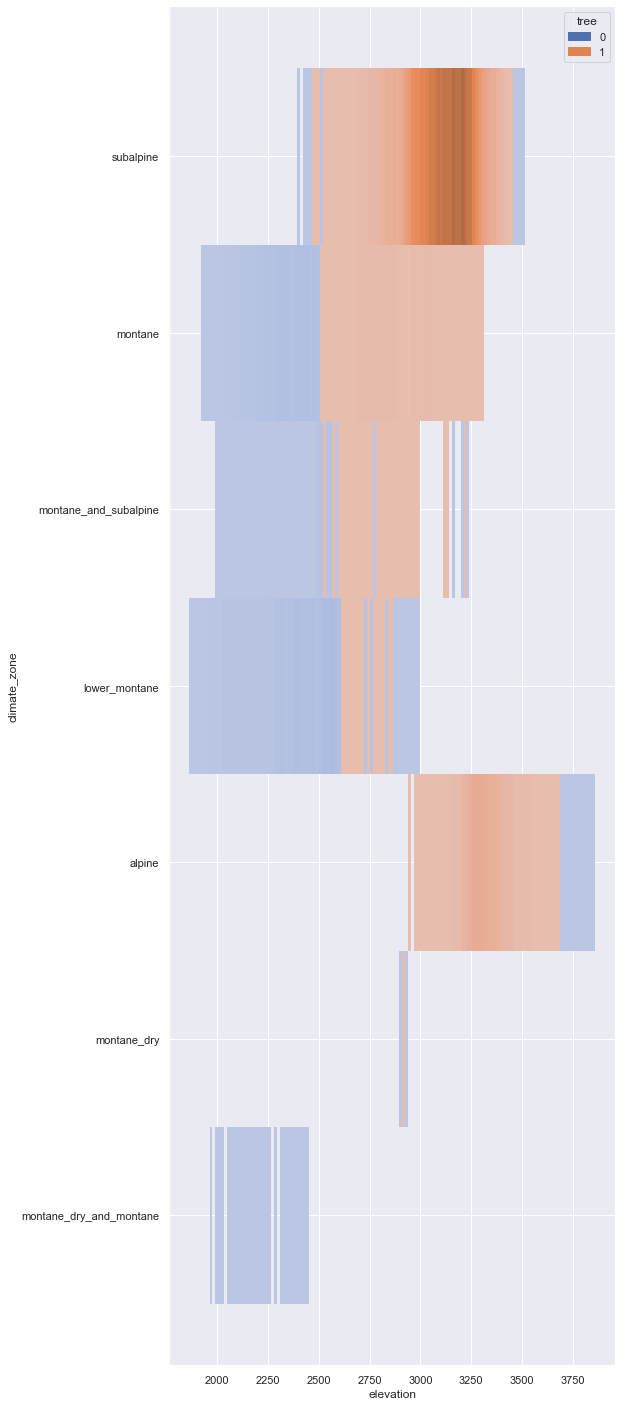

In [162]:
sns.histplot(data=full, x='elevation', y='climate_zone', hue='tree')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'subalpine'),
  Text(1, 0, 'montane'),
  Text(2, 0, 'montane_and_subalpine'),
  Text(3, 0, 'lower_montane'),
  Text(4, 0, 'alpine'),
  Text(5, 0, 'montane_dry'),
  Text(6, 0, 'montane_dry_and_montane')])

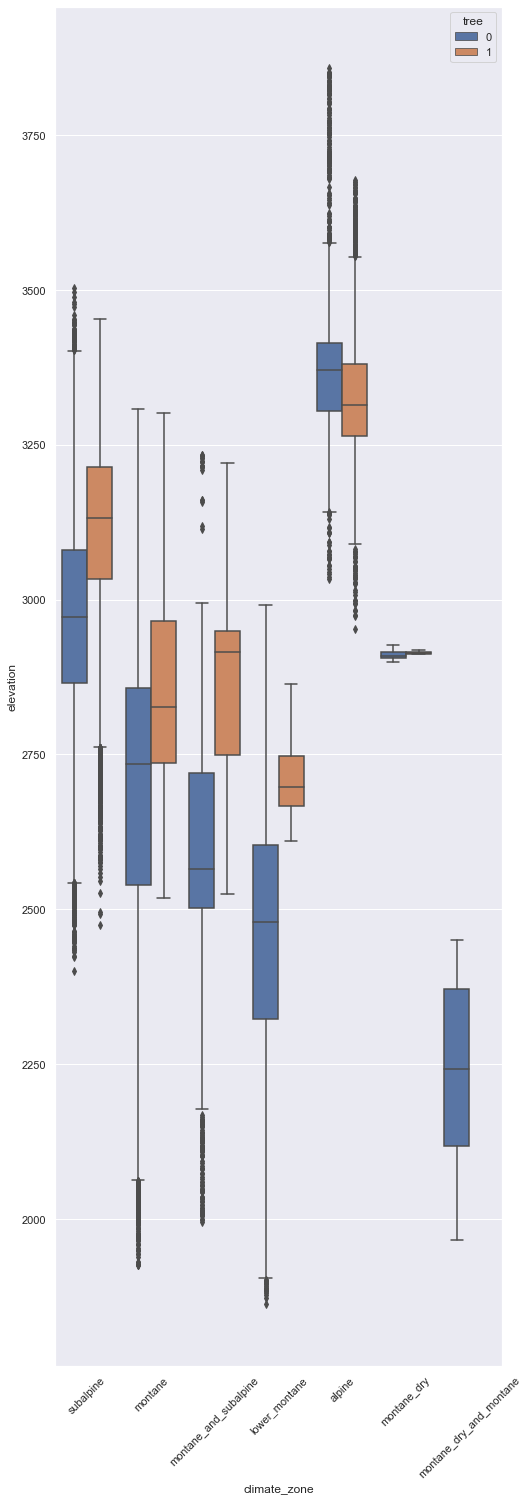

In [164]:
sns.boxplot(data=full, x='climate_zone', y='elevation', hue='tree')
plt.xticks(rotation=45)
#The climate zones are pretty separate for elevation, at least for a few climate zone categories - that will be helpful

In [38]:
logreg = LogisticRegression()
logreg.fit(train_raw[0], train_raw[1])
predictions  = logreg.predict(train_raw[0])
logreg.score(train_raw[0], train_raw[1])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7499526686287672

Spruce vs nonspruce in predictions


0.4661602907035429

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.7499526686287672

0.6756347101174688

0.593852595517914

0.6321093947834895

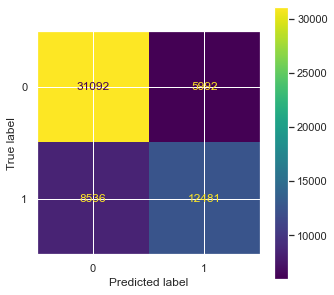

In [39]:

unique, counts = numpy.unique(predictions, return_counts=True)
print("Spruce vs nonspruce in predictions")
display(counts[1]/counts[0]) 

#Here we have a lower proportion - we missed some spruces. Lets look at the confusion matrix 
sns.set(rc={'figure.figsize':(5,5)})
display(plot_confusion_matrix(logreg, train_raw[0], train_raw[1]))
#So: we've got some false negatives 
display(logreg.score(train_raw[0], train_raw[1]))
display(precision_score(train_raw[1], predictions))
display(recall_score(train_raw[1], predictions))
display(f1_score(train_raw[1], predictions))

#So thats just off of elevation. Lets add some other pieces to it. 


In [40]:
train_raw[0].index == train[0].index
#Since the seed for the train split was the same, we receive the same rows, so we essentially have the same data in two different formats 

array([ True,  True,  True, ...,  True,  True,  True])

In [41]:
def metrics(predictions, true):
    sns.set(rc={'figure.figsize':(5,5)})
    display(plot_confusion_matrix(logreg, X, y))
    #So: we've got some false negatives 

    display(precision_score(y, predictions))
    display(recall_score(y, predictions))
    display(f1_score(y, predictions))
    #Which do I want to prioritize? 
    # Recall, precision, or f1? 
    # Recall: are we worried about false negatives? Not so much - spruces are not exactly rare 
    # Precision: assuming that the researchers then manually go out to visit the area, we are concerned about false positives. 
    #p_curve, r_curve, t_curve = precision_recall_curve(y_test, lm.predict_proba(X_test)[:,1])
    
def auc(y_train, y_pred):
    fp, tp, thresholds = roc_curve(y_train, y_pred)
    auc = auc(fp, tp)
    
    return auc



    

In [42]:
#When talking with Jason, he mentioned throwing the data at some models, and going from there. So, lets go 
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [43]:
lr = LogisticRegression(solver='saga')

#lr.fit(train_raw[0], train_raw[1])
#Doesnt converge
#Maybe not easily fitted by logistic regression? Can we scale? Limit features? 
print(train_raw[0].columns)
temp_x = train_raw[0][['elevation','aspect', 'slope','h_water', 'v_water', 'h_road', 'shade_9', 'shade_noon', 'shade_3']]
lr.fit(temp_x, train_raw[1])
lr.score(temp_x, train_raw[1])

Index(['elevation', 'aspect', 'slope', 'h_water', 'v_water', 'h_road',
       'shade_9', 'shade_noon', 'shade_3', 'h_fire', 'wilderness_1',
       'wilderness_2', 'wilderness_3', 'wilderness_4', 'soil_type_1',
       'soil_type_2', 'soil_type_3', 'soil_type_4', 'soil_type_5',
       'soil_type_6', 'soil_type_7', 'soil_type_8', 'soil_type_9',
       'soil_type_10', 'soil_type_11', 'soil_type_12', 'soil_type_13',
       'soil_type_14', 'soil_type_15', 'soil_type_16', 'soil_type_17',
       'soil_type_18', 'soil_type_19', 'soil_type_20', 'soil_type_21',
       'soil_type_22', 'soil_type_23', 'soil_type_24', 'soil_type_25',
       'soil_type_26', 'soil_type_27', 'soil_type_28', 'soil_type_29',
       'soil_type_30', 'soil_type_31', 'soil_type_32', 'soil_type_33',
       'soil_type_34', 'soil_type_36', 'soil_type_37', 'soil_type_38',
       'soil_type_39', 'soil_type_40', 'climate_zone_lower_montane',
       'climate_zone_montane', 'climate_zone_montane_and_subalpine',
       'climate_zone_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7499698800364882

In [138]:
clf = RandomForestClassifier(bootstrap=True, random_state=0)

clf.fit(train_raw[0],train_raw[1])
print(clf.score(train_raw[0], train_raw[1]))
#Yeah, ok, I need a limiting factor, or this is grossly overfitting:) Of course 
predictions = clf.predict(train_raw[0])
print(f"precision:{precision_score(train_raw[1],predictions)}")
print(f"recall:{recall_score(train_raw[1],predictions)}")
print(f"F1:{f1_score(train_raw[1],predictions)}")

1.0
precision:1.0
recall:1.0
F1:1.0


In [139]:
predictions = clf.predict(val_raw[0])
print(f"score:{clf.score(val_raw[0],val_raw[1])}")
print(f"precision:{precision_score(val_raw[1],predictions)}")
print(f"recall:{recall_score(val_raw[1],predictions)}")
print(f"F1:{f1_score(val_raw[1],predictions)}")
#The clf works on the validation set works relatively well 


score:0.931047094511736
precision:0.9277818810009639
recall:0.8784402038639326
F1:0.9024370939952391


array([[157788,   8527],
       [ 14664,  80476]])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


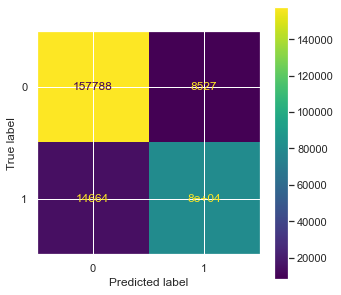

In [46]:
display(confusion_matrix(val_raw[1],predictions))
display(plot_confusion_matrix(clf, val_raw[0], val_raw[1]))

In [91]:
# train_raw[0].to_csv('train_x.csv')
# train_raw[1].to_csv('train_y.csv')


import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import numpy
from sklearn.metrics import precision_recall_curve 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import xgboost




In [60]:
train_raw[0].columns

Index(['elevation', 'aspect', 'slope', 'h_water', 'v_water', 'h_road',
       'shade_9', 'shade_noon', 'shade_3', 'h_fire', 'wilderness_1',
       'wilderness_2', 'wilderness_3', 'wilderness_4', 'soil_type_1',
       'soil_type_2', 'soil_type_3', 'soil_type_4', 'soil_type_5',
       'soil_type_6', 'soil_type_7', 'soil_type_8', 'soil_type_9',
       'soil_type_10', 'soil_type_11', 'soil_type_12', 'soil_type_13',
       'soil_type_14', 'soil_type_15', 'soil_type_16', 'soil_type_17',
       'soil_type_18', 'soil_type_19', 'soil_type_20', 'soil_type_21',
       'soil_type_22', 'soil_type_23', 'soil_type_24', 'soil_type_25',
       'soil_type_26', 'soil_type_27', 'soil_type_28', 'soil_type_29',
       'soil_type_30', 'soil_type_31', 'soil_type_32', 'soil_type_33',
       'soil_type_34', 'soil_type_36', 'soil_type_37', 'soil_type_38',
       'soil_type_39', 'soil_type_40', 'climate_zone_lower_montane',
       'climate_zone_montane', 'climate_zone_montane_and_subalpine',
       'climate_zone_

In [88]:
xb = XGBClassifier()

In [89]:

# xb.fit(train_raw[0][['elevation','aspect','slope','h_water','v_water','h_road','shade_9','shade_noon','shade_3','h_fire','wilderness_1','wilderness_2','wilderness_3','wilderness_4','soil_type_1','soil_type_2', 'soil_type_3', 'soil_type_4', 'soil_type_5','soil_type_6', 'soil_type_7', 'soil_type_8', 'soil_type_9', 'soil_type_10', 'soil_type_11', 'soil_type_12', 'soil_type_13','soil_type_14', 'soil_type_15', 'soil_type_16', 'soil_type_17', 'soil_type_18', 'soil_type_19', 'soil_type_20', 'soil_type_21','soil_type_22', 'soil_type_23', 'soil_type_24', 'soil_type_25','soil_type_26', 'soil_type_27', 'soil_type_28', 'soil_type_29','soil_type_30', 'soil_type_31', 'soil_type_32', 'soil_type_33','soil_type_34', 'soil_type_36', 'soil_type_37', 'soil_type_38','soil_type_39', 'soil_type_40','climate_zone_lower_montane',
#        'climate_zone_montane', 'climate_zone_montane_and_subalpine','climate_zone_montane_dry', 'climate_zone_montane_dry_and_montane' ,  'climate_zone_subalpine', 'geo_zone_alluvium', 'geo_zone_glacial','geo_zone_ingeous_and_metamorphic', 'geo_zone_mixed_sedimentary','slope_direction_east', 'slope_direction_north', 'slope_direction_south', 'slope_direction_west']], train[1])
# #xb.fit(train_raw[0],train_raw[1])

[22:41:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
xb.fit(train_raw[0], train_raw[1])


[22:41:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [92]:
xb.score(train_raw[0],train_raw[1])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.9007159945611951

In [94]:
xb.score(val_raw[0],val_raw[1])
#Validation .88 - pretty close to training. A tiny  bit lower than random forest, but I like that the training isnt 1 - maybe we can tune some hyperparameters 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.882455196747058

So, parameters: 
max_depth - deeper tree, better performance, more change to overfit. Default 6 
learning rate: step size, low make computation slower - but possible better optimum. 
n_estimators: number of trees. 
colsample_by_tree: percentage of columns to sample  by each tree 

alpha: L1 reg weights 
lambda: L2 reg weights 


The big heavyweights seems to be max depth 

In [98]:
#Lets start small - what happens if we set max depth higher and lower? 
xb1 = XGBClassifier(max_depth=2)
xb2 = XGBClassifier(max_depth=10)

xb1.fit(train_raw[0], train_raw[1])
xb2.fit(train_raw[0], train_raw[1])

print(f'1 train :{xb1.score(train_raw[0], train_raw[1])}')
print(f'2 train :{xb2.score(train_raw[0], train_raw[1])}')

print(f'1 val :{xb1.score(val_raw[0], val_raw[1])}')
print(f'2 val :{xb2.score(val_raw[0], val_raw[1])}')

#So - higher depth - higher performance. Cool cool. But we dont really want to go all the way up, we should find the optimum. It will be greater than 6 - the default. 


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:21:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [99]:
xb1 = XGBClassifier(n_estimators=50)
xb2 = XGBClassifier(n_estimators=300)

xb1.fit(train_raw[0], train_raw[1])
xb2.fit(train_raw[0], train_raw[1])

print(f'1 train :{xb1.score(train_raw[0], train_raw[1])}')
print(f'2 train :{xb2.score(train_raw[0], train_raw[1])}')

print(f'1 val :{xb1.score(val_raw[0], val_raw[1])}')
print(f'2 val :{xb2.score(val_raw[0], val_raw[1])}')

#Scores increase with more estimators, thats true. 
#But should also optimize, does the val score at some point stop going up? Also check out defaults above the default. 

[12:23:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:23:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


1 train :0.872394623156228
2 train :0.9576169084869451


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


1 val :0.8602224564875971


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


2 val :0.9216281921645404


In [125]:
from sklearn.model_selection import GridSearchCV
xb3 = XGBClassifier()
#Is this possible? Can this really be done? 
params = { 'max_depth': [10,11],
           'n_estimators': [500,1000],
                            #, 500, 1000],
           'colsample_bytree': [1]}
                                #,0.3,0.5, 0.7,0.9, 1]}

x = GridSearchCV(xb3, params, cv = 2, scoring='accuracy')
x.fit(train_raw[0],train_raw[1])

print(x.best_params_)
print(x.best_score_)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:51:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:51:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:52:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:54:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:54:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:55:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:56:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:58:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 1, 'max_depth': 11, 'n_estimators': 1000}
0.9382196519853359


In [118]:
print(XGBClassifier(max_depth=10, n_estimators=500, colsample_bytree=.1).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1]))
print(XGBClassifier(max_depth=10, n_estimators=1000, colsample_bytree=.1).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1]))
print(XGBClassifier(max_depth=10, n_estimators=1500, colsample_bytree=.1).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1]))


[20:12:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.882364837245326
[20:12:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.8861857533185603
[20:13:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.8945332501452207


In [120]:
print(XGBClassifier(max_depth=9, n_estimators=500, colsample_bytree=.1).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1]))
print(XGBClassifier(max_depth=10, n_estimators=500, colsample_bytree=.1).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1]))
print(XGBClassifier(max_depth=11, n_estimators=500, colsample_bytree=.1).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1]))


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.879245283018868
[20:17:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.882364837245326
[20:17:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.8848002409586713


In [124]:
print(XGBClassifier(max_depth=10, n_estimators=1000, colsample_bytree=.75).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1]))
print(XGBClassifier(max_depth=10, n_estimators=1000, colsample_bytree=1).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1]))
print(XGBClassifier(max_depth=10, n_estimators=1000, colsample_bytree=.9).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1]))


[20:40:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.9558615348206794


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:42:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.9569845743422043


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:44:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.9568813063402251


We have to do the above in pieces, because otherwise it takes for flippin ever 
Testing maxdepth: 
So: 
{'colsample_bytree': 0.1, 'max_depth': 10, 'n_estimators': 100}
    
Maxdepth 10 is the best, not 30. Lets see if the same holds when we up the number of estimators 
Holds for nestimators 1000 too. Max depth 10. Probably due to the fact that we dont have that many features, if we don't consider all the dummy variables 

Lets test the numbers around 10 - maybe one higher or one lower is better? 
Depth 12 is preferable. Checking again w/ higher numbers - 12 holds, keeping 12. 
upping number of estimators - 11. Somewhere around there. Higher estimator numbers - lower depth ok. N estimators = 1000, max_depth=10 highest. Mk. 
That makes sense, as the higher estimator mean slower training but usually higher pattern catching - throwing reosurces at a problem.
{'colsample_bytree': 0.1, 'max_depth': 10, 'n_estimators': 1000} - option of max depth and nestimators 
0.867584034698198


Testing n estimators 
300,500,1000,1500 w/ max_depth 10

yeah yeah, fine, the higher the number of estimators, the happier this is. Is there a significant difference? 
Lets train one more time, and see how much of a difference - 1500 is slower. 
The differences are pretty negligible, I think I went about this the wrong way. 
Lets go back to colsample



#So bootstrapping seems to not be a job. Lets test precisely how 
1 has slightly higher validation scores, but its relatively negligible. Assumping we dont really want bootstrapping, and 1 is fine to have, lets do it. 


#Now lets rerun the analysis with max depth and estimators 
#Looks like max levels 11 
#and col estimators 1 
#and estimators 1000


In [131]:
XGBClassifier(max_depth=11, n_estimators=1000, colsample_bytree=1).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1])
#95 validation score - not bad! Still worse than random forest. 
#Can I make it better? What about upping the nestimators? 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [129]:
XGBClassifier(max_depth=15, n_estimators=1500, colsample_bytree=1).fit(train_raw[0],train_raw[1]).score(val_raw[0],val_raw[1])
#sLOW AS all heck
# And not a great improvement at all. So naaah 

[21:27:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.9594888233902025

In [136]:
#So this is higher than random forest - thats cool. 
#We're fitting for a large class, so Im not super worried that accuracy is not my best metric. 
#But if we're thinking father, 

x = XGBClassifier(max_depth=11, n_estimators=1000, colsample_bytree=1)
x.fit(train_raw[0],train_raw[1])


[23:38:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [137]:
predictions = clf.predict(val_raw[0])
print(f"score rf:{clf.score(val_raw[0],val_raw[1])}")
print(f"precision rf:{precision_score(val_raw[1],predictions)}")
print(f"recall rf:{recall_score(val_raw[1],predictions)}")
print(f"F1 rf:{f1_score(val_raw[1],predictions)}")
#The clf works on the validation set works relatively well 


predictions = x.predict(val_raw[0])
print(f"score xg:{x.score(val_raw[0],val_raw[1])}")
print(f"precision xg:{precision_score(val_raw[1],predictions)}")
print(f"recall xg:{recall_score(val_raw[1],predictions)}")
print(f"F1 xg:{f1_score(val_raw[1],predictions)}")
#The clf works on the validation set works relatively well 

#XGBoost performs better across all metrics. So thats cool


score rf:0.9263268862545987
precision rf:0.9209630167513835
recall rf:0.8718857413772668
F1 rf:0.8957526606755802


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


score xg:0.9577719928572965
precision xg:0.9484949108496354
recall xg:0.9344198174706649
F1 xg:0.9414047573557508


In [142]:
set(train_raw[0].index).intersection(set(val_raw[0].index))

set()

In [143]:
train_raw[0]

,elevation,aspect,slope,h_water,v_water,h_road,shade_9,shade_noon,shade_3,h_fire,...,climate_zone_montane_dry_and_montane,climate_zone_subalpine,geo_zone_alluvium,geo_zone_glacial,geo_zone_ingeous_and_metamorphic,geo_zone_mixed_sedimentary,slope_direction_east,slope_direction_north,slope_direction_south,slope_direction_west
378729,3145,32,14,228,17,1652,216,210,126,1830,...,0,1,0,0,1,0,0,1,0,0
160730,2915,87,14,120,27,3133,240,215,102,2024,...,0,1,0,0,1,0,1,0,0,0
298234,2960,68,5,42,2,2554,225,230,139,1825,...,0,1,0,1,0,0,1,0,0,0
433071,3068,0,5,30,0,2290,213,231,156,2131,...,0,1,0,0,1,0,0,1,0,0
161023,3155,180,15,228,46,2873,224,248,152,3388,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378790,2911,301,28,201,68,1347,133,216,217,1215,...,0,1,0,0,1,0,0,0,0,1
397238,3243,90,12,499,116,569,238,221,112,918,...,0,1,0,0,1,0,1,0,0,0
564956,2894,215,4,255,13,1116,216,243,164,2293,...,0,1,0,0,1,0,0,0,1,0
520801,2600,229,25,242,72,969,174,253,207,1168,...,0,0,0,0,1,0,0,0,0,1


<AxesSubplot:>

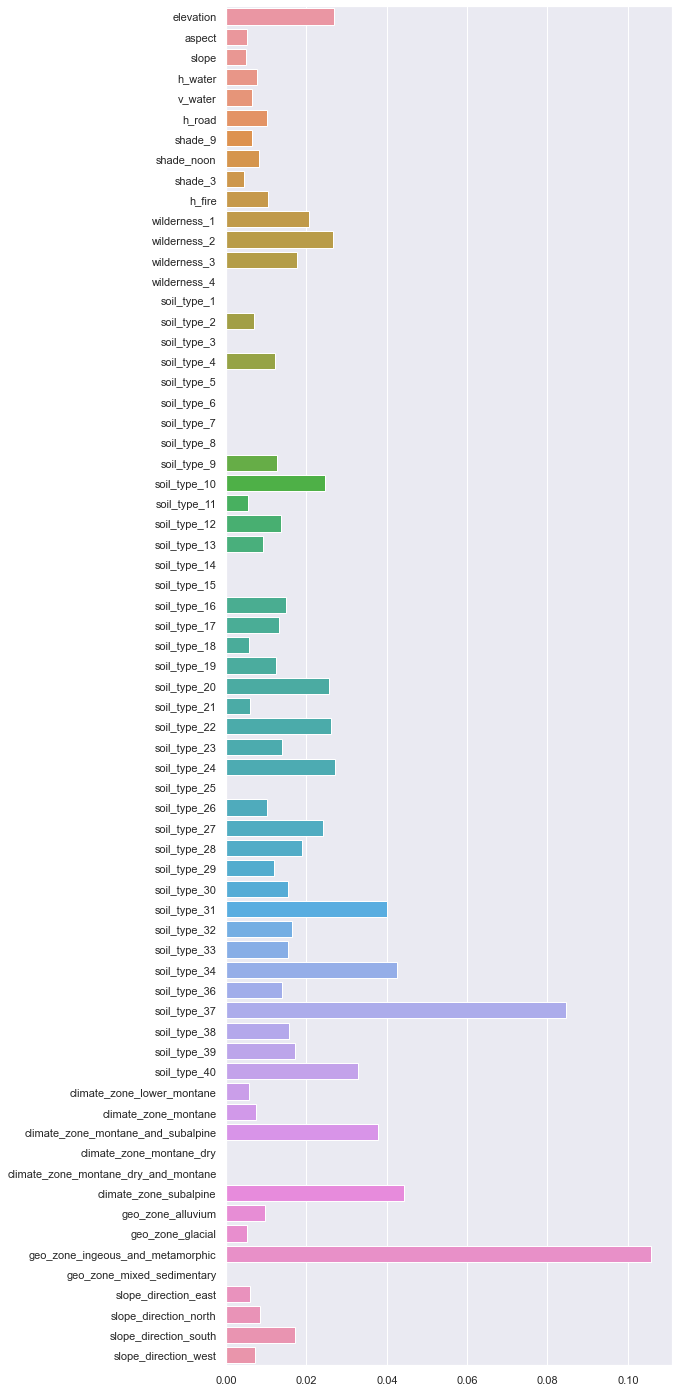

In [158]:
#Feature Importances
sns.set(rc={'figure.figsize':(8,25)})
sns.barplot(y=train_raw[0].columns, x=x.feature_importances_)

In [ ]:
#By the looks of this, a few soil types are not super useful, and a geo zone.
#Its fascinating that geozone ingenous and metamorphic is very important to this classification- even more important than elevation. 


